<a href="https://colab.research.google.com/github/Alex-Witt/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=21.475280858269432, mobile=True), User(purchased=False, time_on_site=169.85373844562977, mobile=True), User(purchased=False, time_on_site=101.69642910541417, mobile=True), User(purchased=True, time_on_site=70.36578332727052, mobile=True), User(purchased=False, time_on_site=163.95499273946544, mobile=True), User(purchased=False, time_on_site=216.15855550491418, mobile=True), User(purchased=False, time_on_site=99.54284905012645, mobile=True), User(purchased=False, time_on_site=472.7544356770138, mobile=False), User(purchased=False, time_on_site=54.56162276009301, mobile=True), User(purchased=False, time_on_site=228.61942584100984, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,21.475281,True
1,False,169.853738,True
2,False,101.696429,True
3,True,70.365783,True
4,False,163.954993,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.571073628979256,6.74982340170855,6.790364910546123,6.826373898924384,8.207868850608719,8.45284190723197,8.500664496929213,8.925178051594207,9.109549745689261,9.335984020797564,...,576.7490180387455,579.1661714410214,581.2673787306877,585.496170310357,589.124630149742,590.228000974103,590.3312879704525,594.4756320941765,594.5152091965535,599.6122291728914
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,1,1,0,1,...,1,0,0,0,1,1,0,1,1,1
True,0,0,0,0,1,0,0,0,1,0,...,0,1,1,1,0,0,1,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.977, 124.379]","(124.379, 243.188]","(243.188, 361.996]","(361.996, 480.804]","(480.804, 599.612]"
purchased,,,,,
False,248,208,116,27,26
True,116,129,95,19,16


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.977, 124.379]","(124.379, 243.188]","(243.188, 361.996]","(361.996, 480.804]","(480.804, 599.612]"
purchased,,,,,
False,0.681319,0.617211,0.549763,0.586957,0.619048
True,0.318681,0.382789,0.450237,0.413043,0.380952


In [8]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.712,0.596
True,0.288,0.404


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

# Data Import and Cursory Observation

In [0]:
import matplotlib.pyplot as plt
import pandas as np
import numpy as np

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/Alex-Witt/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

print(df.shape)
print(df.isnull().sum())
df.head()

(1200, 4)
Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


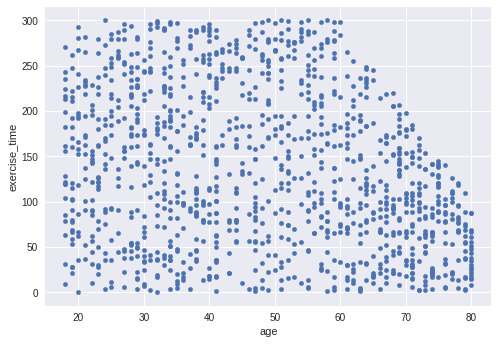

In [12]:
df.plot.scatter(x = 'age' , y = 'exercise_time');

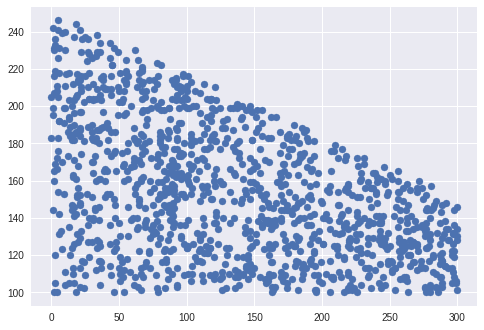

In [13]:
plt.scatter(df.exercise_time , df.weight )

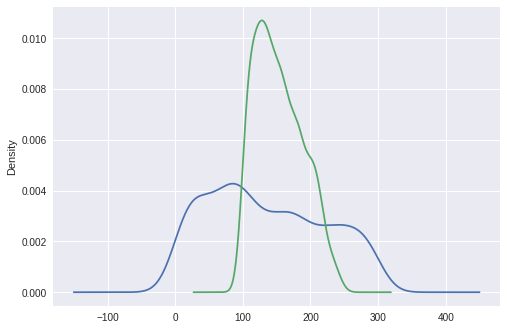

In [14]:
df.exercise_time.plot.density();
df.weight.plot.density();

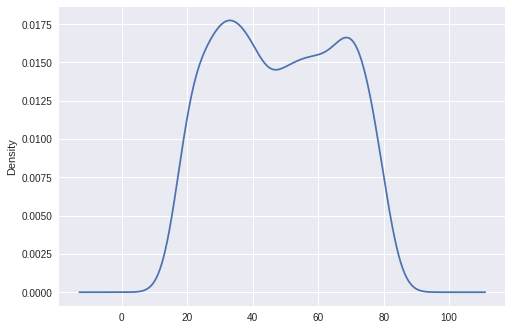

In [15]:
df.age.plot.density();

In [16]:
'''def make_bins(n_bins):
  exercisem = pd.cut(df.exercise_time,n_bins)
  age = pd.cut(df.age,n_bins)
  weight = pd.cut(df.weight,n_bins)
  return
  
  '''


'def make_bins(n_bins):\n  exercisem = pd.cut(df.exercise_time,n_bins)\n  age = pd.cut(df.age,n_bins)\n  weight = pd.cut(df.weight,n_bins)\n  return\n  \n  '

In [0]:
#Let's start with 8 bins on the x and y axis

n_bins = 8
weight = pd.cut(df.weight,n_bins)
exercise = pd.cut(df.exercise_time,n_bins)
age = pd.cut(df.age,n_bins)

def cross(dep , ind):
  res = pd.crosstab(dep,ind)
  return res

def crossum(dep , ind):
  resum = pd.crosstab(dep.count(),ind)
  return resum

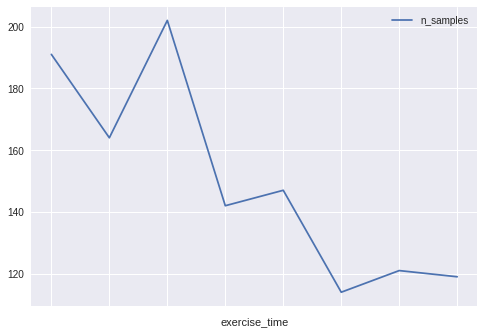

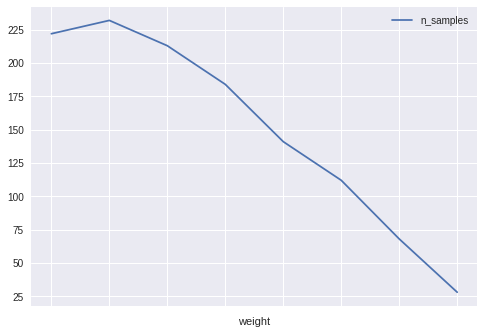

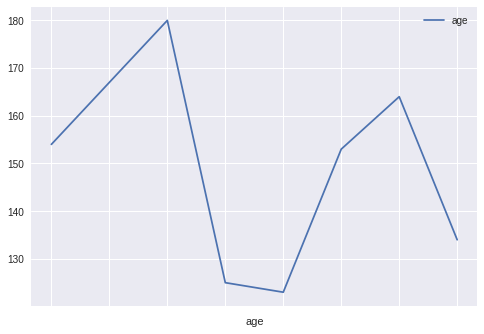

In [140]:
n_age = pd.pivot_table(crossum(exercise, age), columns = 'age')
n_ex = pd.pivot_table(crossum(age, exercise) , columns = 'exercise_time')
n_w = pd. pivot_table(crossum(age , weight) , columns = 'weight')

n_w.columns = ['n_samples']
n_ex.columns = ['n_samples']
n_w.columns = ['n_samples']



n_ex.plot.line()
n_w.plot.line()
n_age.plot.line()

exercise_time,"(-0.3, 37.5]","(37.5, 75.0]","(75.0, 112.5]","(112.5, 150.0]","(150.0, 187.5]","(187.5, 225.0]","(225.0, 262.5]","(262.5, 300.0]"
weight,,,,,,,,
"(99.854, 118.25]",22,22,23,26,29,31,29,40
"(118.25, 136.5]",20,18,28,23,26,34,34,49
"(136.5, 154.75]",24,20,32,18,39,23,33,24
"(154.75, 173.0]",20,25,42,24,24,18,25,6
"(173.0, 191.25]",28,25,32,24,24,8,0,0
"(191.25, 209.5]",30,24,28,25,5,0,0,0
"(209.5, 227.75]",23,26,17,2,0,0,0,0
"(227.75, 246.0]",24,4,0,0,0,0,0,0


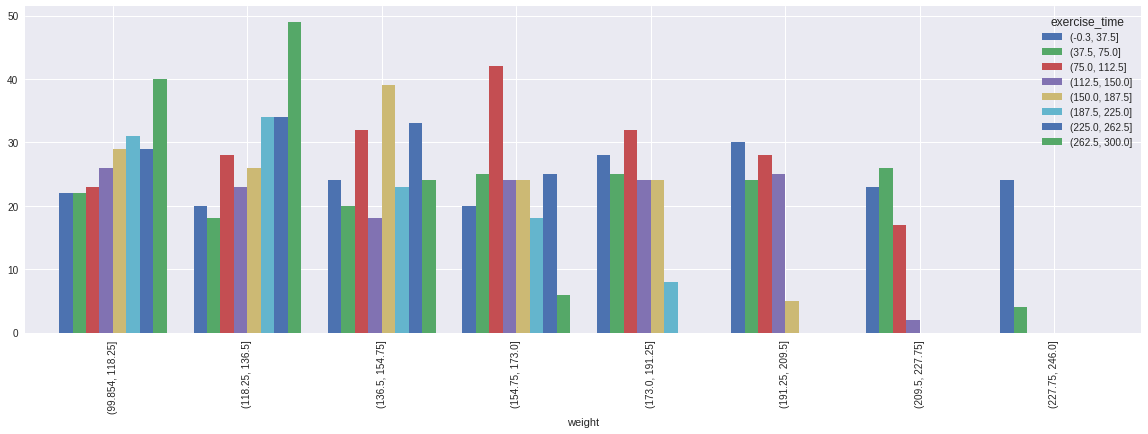

In [128]:
#Lets start with the most obvious inference, that length of excercise is associated with weight. 

cross(weight,exercise).plot.bar(figsize = (20,6),width = .8)
cross(weight,exercise)

age,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]","(72.25, 80.0]"
weight,,,,,,,,
"(99.854, 118.25]",31,40,44,20,24,24,21,18
"(118.25, 136.5]",26,28,40,31,29,31,29,18
"(136.5, 154.75]",30,34,31,23,22,27,27,19
"(154.75, 173.0]",30,29,17,22,17,19,29,21
"(173.0, 191.25]",16,14,21,11,15,22,19,23
"(191.25, 209.5]",14,8,20,8,8,18,20,16
"(209.5, 227.75]",3,12,5,7,7,10,10,14
"(227.75, 246.0]",4,2,2,3,1,2,9,5


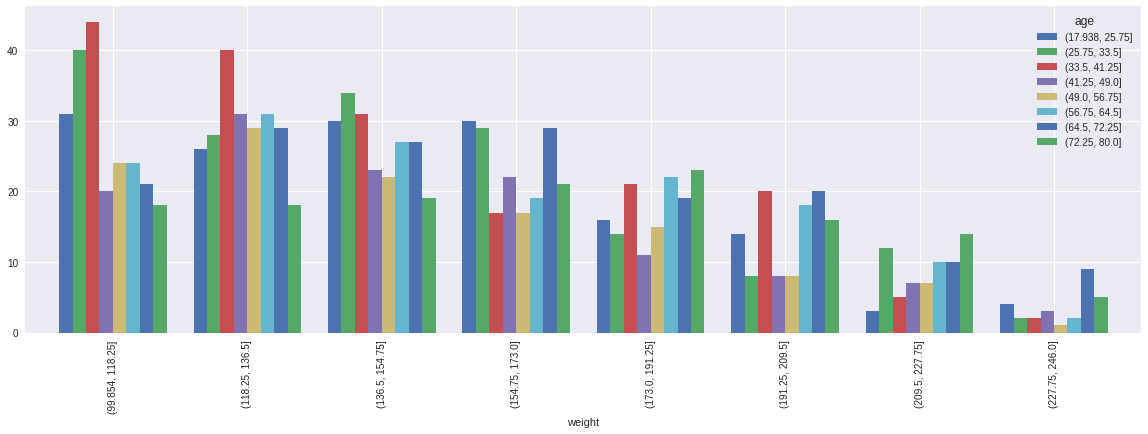

In [52]:
#The clear global trend continues. Let's see if we can catch any other global trends. 

cross(weight, age).plot.bar(figsize = (20,6),width = .8)
cross(weight,age)

weight,"(99.854, 118.25]","(118.25, 136.5]","(136.5, 154.75]","(154.75, 173.0]","(173.0, 191.25]","(191.25, 209.5]","(209.5, 227.75]","(227.75, 246.0]"
age,,,,,,,,
"(17.938, 25.75]",31,26,30,30,16,14,3,4
"(25.75, 33.5]",40,28,34,29,14,8,12,2
"(33.5, 41.25]",44,40,31,17,21,20,5,2
"(41.25, 49.0]",20,31,23,22,11,8,7,3
"(49.0, 56.75]",24,29,22,17,15,8,7,1
"(56.75, 64.5]",24,31,27,19,22,18,10,2
"(64.5, 72.25]",21,29,27,29,19,20,10,9
"(72.25, 80.0]",18,18,19,21,23,16,14,5


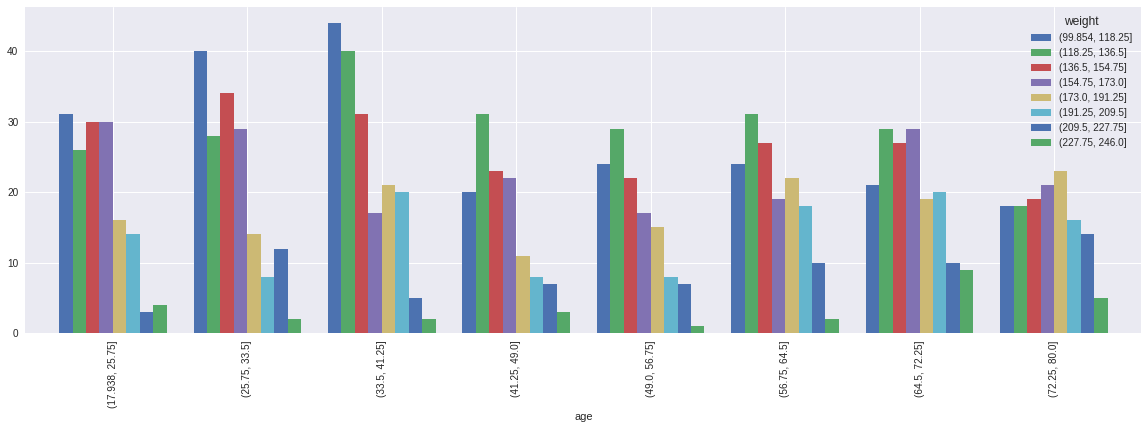

In [51]:
#Well, that makes send. You have a nice spread of people excercising across each age group, with smaller sample of older individuals. 

cross(age,weight).plot.bar(figsize = (20,6),width = .8)
cross(age,weight)

age,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]","(72.25, 80.0]"
exercise_time,,,,,,,,
"(-0.3, 37.5]",18,19,27,12,12,27,35,41
"(37.5, 75.0]",16,25,17,14,13,17,27,35
"(75.0, 112.5]",20,13,35,18,13,25,41,37
"(112.5, 150.0]",22,18,14,10,17,18,23,20
"(150.0, 187.5]",24,22,21,16,15,21,27,1
"(187.5, 225.0]",23,20,23,11,11,17,9,0
"(225.0, 262.5]",19,28,19,23,16,14,2,0
"(262.5, 300.0]",12,22,24,21,26,14,0,0


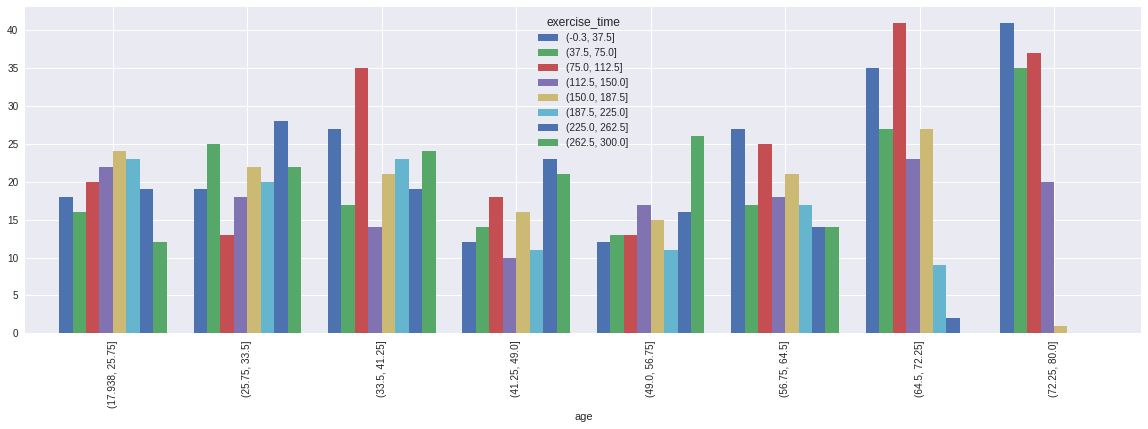

In [84]:
cross(age, exercise).plot.bar(figsize = (20,6),width = .8)
cross(exercise, age)

In [0]:
b = crossum(age, exercise)

In [105]:
-crossum(weight, exercise)

exercise_time,"(-0.3, 37.5]","(37.5, 75.0]","(75.0, 112.5]","(112.5, 150.0]","(150.0, 187.5]","(187.5, 225.0]","(225.0, 262.5]","(262.5, 300.0]"
row_0,,,,,,,,
1200,191,164,202,142,147,114,121,119


In [122]:
age.value_counts()

(33.5, 41.25]      180
(25.75, 33.5]      167
(64.5, 72.25]      164
(17.938, 25.75]    154
(56.75, 64.5]      153
(72.25, 80.0]      134
(41.25, 49.0]      125
(49.0, 56.75]      123
Name: age, dtype: int64

In [121]:
weight.value_counts()

(118.25, 136.5]     232
(99.854, 118.25]    222
(136.5, 154.75]     213
(154.75, 173.0]     184
(173.0, 191.25]     141
(191.25, 209.5]     112
(209.5, 227.75]      68
(227.75, 246.0]      28
Name: weight, dtype: int64

In [120]:
exercise.value_counts()

(75.0, 112.5]     202
(-0.3, 37.5]      191
(37.5, 75.0]      164
(150.0, 187.5]    147
(112.5, 150.0]    142
(225.0, 262.5]    121
(262.5, 300.0]    119
(187.5, 225.0]    114
Name: exercise_time, dtype: int64

In [106]:
crossum(weight, age)

age,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]","(72.25, 80.0]"
row_0,,,,,,,,
1200,154,167,180,125,123,153,164,134


In [103]:
crossum(age, weight)

weight,"(99.854, 118.25]","(118.25, 136.5]","(136.5, 154.75]","(154.75, 173.0]","(173.0, 191.25]","(191.25, 209.5]","(209.5, 227.75]","(227.75, 246.0]"
row_0,,,,,,,,
1200,222,232,213,184,141,112,68,28


In [93]:
()b.head()

exercise_time,"(-0.3, 37.5]","(37.5, 75.0]","(75.0, 112.5]","(112.5, 150.0]","(150.0, 187.5]","(187.5, 225.0]","(225.0, 262.5]","(262.5, 300.0]"
row_0,,,,,,,,
1200,191,164,202,142,147,114,121,119


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)